# **Analysis Notebook Overview**

This Jupyter notebook is a comprehensive nuclear physics analysis tool for studying proton-induced nuclear reactions on various metal foils for medical isotope production.

#### **What the notebook contains:**

* *Imports & Configuration:* Loads essential libraries, configures matplotlib parameters and Sets up file paths.

* *Detector Calibration & Efficiency Analysis:* Performs gamma-ray detector efficiency calibration using standard sources, and creates efficiency curves.

* *Activity Decay Analysis*: Analyzes five experiments with varying silver plates, irradiation times (1-3 min), and measurement configurations. Generates activity decay plots.

* *Cross-Section Analysis*: Studies nuclear reaction cross-sections for target materials (Ga, Sn) and monitor foils (Cu, Ni).

* *Stack Analysis & Counting Time Calculation*: Calculates required counting times for isotope detection by modeling proton beam energy loss through layered target stacks.

<br><br>

## **Imports & Configuration**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import curie as ci
import numpy as np
import pandas as pd
from path import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from stack_analysis import StackAnalysis
from cs_analysis import CrossSectionAnalysis
from spectrum_analysis import SpectrumAnalysis
from uncertainties import correlated_values, unumpy

# Configuration for matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.labelsize':   13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (10, 6)})

# Define paths
root_path = Path.cwd().parent 
spec_filename = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path = spec_filename / 'experiment'
spec_test_path = spec_filename / 'test'
tendl_data_path = root_path / 'tendl_data'
fig_path = root_path / 'figs'

<br><br>

## **Detector Calibration & Efficiency Analysis**

In [2]:
def Ci_to_Bq(Ci: float) -> float:
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10

# Calibration source data
isotope_data = {
    '137CS': {'file': 'AA110625_137CS.Spe', 'A0': Ci_to_Bq(11.46e-6), 'ref_date': '02/01/1979 12:00:00'},
    '133BA': {'file': 'AB110625_133BA.Spe', 'A0': Ci_to_Bq(10.78e-6), 'ref_date': '10/01/1988 12:00:00'},
    '152EU': {'file': 'AC110625_152EU.Spe', 'A0': 150e3, 'ref_date': '01/01/2002 12:00:00'}
}

# Create spectra and sources data
cb = ci.Calibration()
spectra = []
sources_list = []

for isotope, data in isotope_data.items():
    # Create spectrum
    sp = ci.Spectrum(spec_calib_path / data['file'])
    sp.isotopes = [isotope]
    spectra.append(sp)
    
    sources_list.append({
        'isotope': isotope,
        'A0': data['A0'],
        'ref_date': data['ref_date']
    })

sources = pd.DataFrame(sources_list)
save_calibration = False

# If calibration is not successful, you may need to run the following line to auto-calibrate Eu-152:
# sp_Eu152.auto_calibrate()
cb.calibrate(spectra, sources=sources)

if save_calibration:
    cb.saveas(root_path / "calibration.json")

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AA110625_137CS.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AB110625_133BA.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AC110625_152EU.Spe


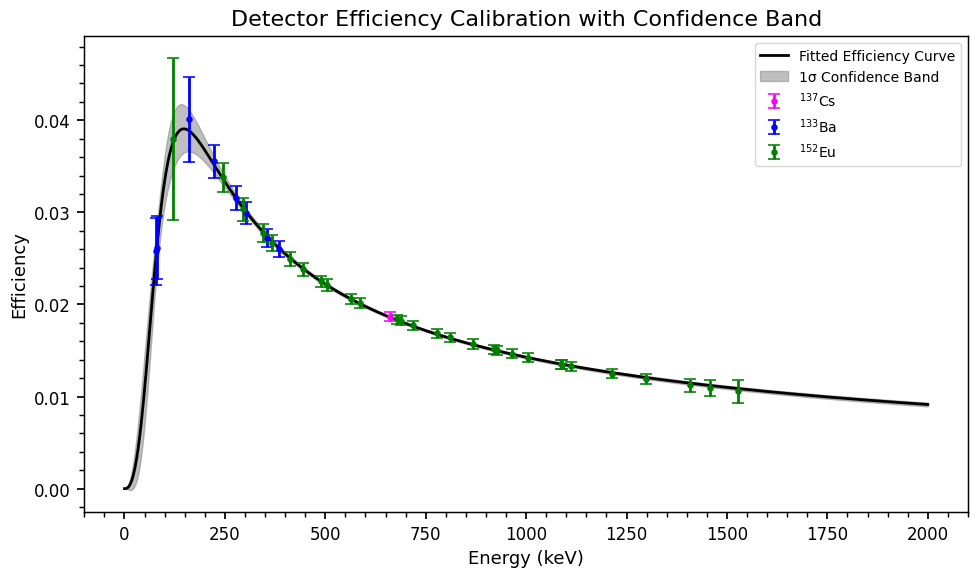

In [3]:
# Extract efficiency data from all spectra
efficiency_data = []
for sp in spectra:
    if sp.peaks is None:
        raise ValueError(f"Peaks not found in spectrum {sp.filename}. Ensure the spectrum is calibrated and has peaks detected.")
    
    for energy, ε, unc_ε, iso_name in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        efficiency_data.append([energy, ε, unc_ε, iso_name])


# Convert to numpy arrays
efficiency_df = pd.DataFrame(efficiency_data, columns=['energy', 'efficiency', 'unc_efficiency', 'isotope'])
isotope_energy_set = efficiency_df['energy'].values
efficiencies = efficiency_df['efficiency'].values
unc_efficiencies = efficiency_df['unc_efficiency'].values


def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)


# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, 
                                        p0=p0, sigma=unc_efficiencies, absolute_sigma=True)

# Generate fitted curve with uncertainties
energy_range = np.linspace(0, 2000, 1000)
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)

# Plotting
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

# Plot data points for each spectrum
colors = ['magenta', 'blue', 'green']
labels = [r'$^{137}$Cs', r'$^{133}$Ba', r'$^{152}$Eu']
for sp, color, label in zip(spectra, colors, labels):
    plt.errorbar(sp.peaks['energy'], sp.peaks['efficiency'], 
                yerr=sp.peaks['unc_efficiency'], fmt='o', label=label, color=color)

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

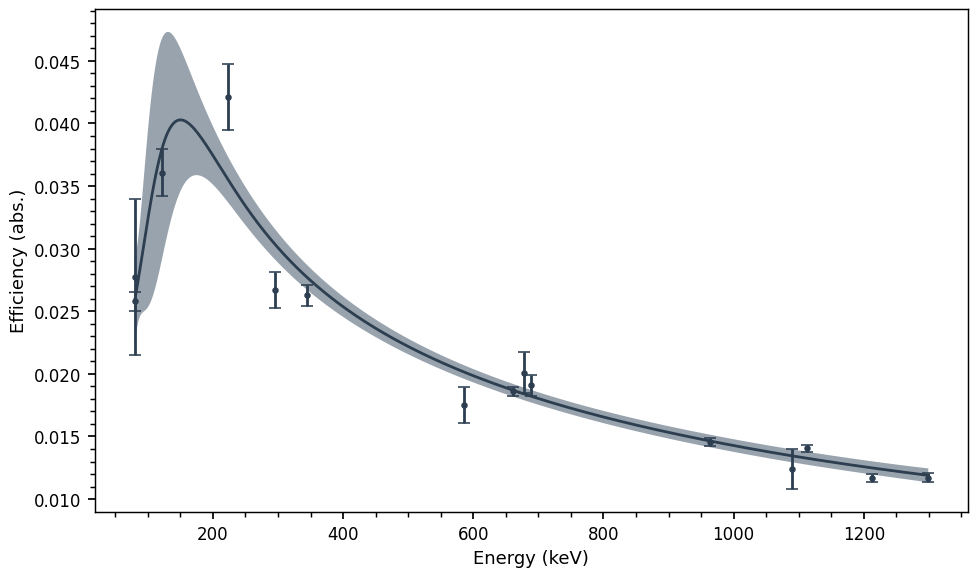

In [4]:
# Plot the efficiency calibration using Curie's built-in function
cb.plot_effcal()

<br><br>

## **Activity Decay Analysis**

#### **Job 1**:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_005.Spe


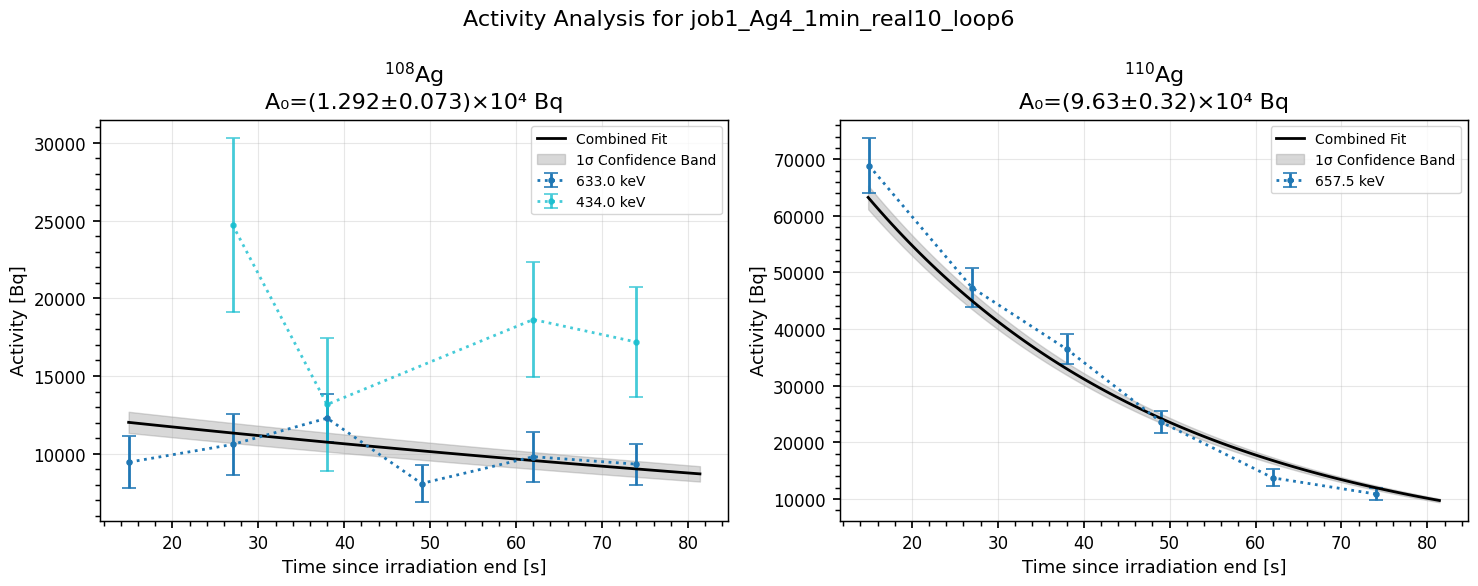

In [5]:
job1_analysis = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)  # type: ignore
job1_analysis.plot_activity()

#### **Job 2**:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_004.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_005.Spe


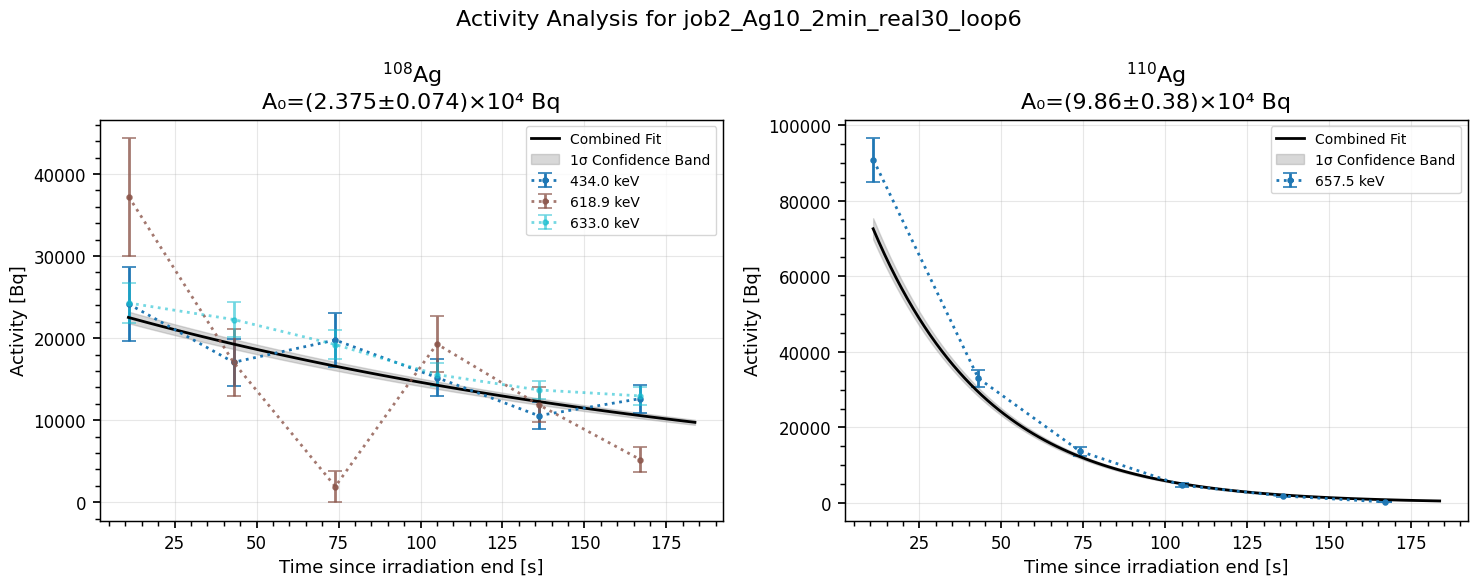

In [6]:
job2_analysis = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)  # type: ignore
job2_analysis.plot_activity()

#### **Job 3:**
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_002.Spe


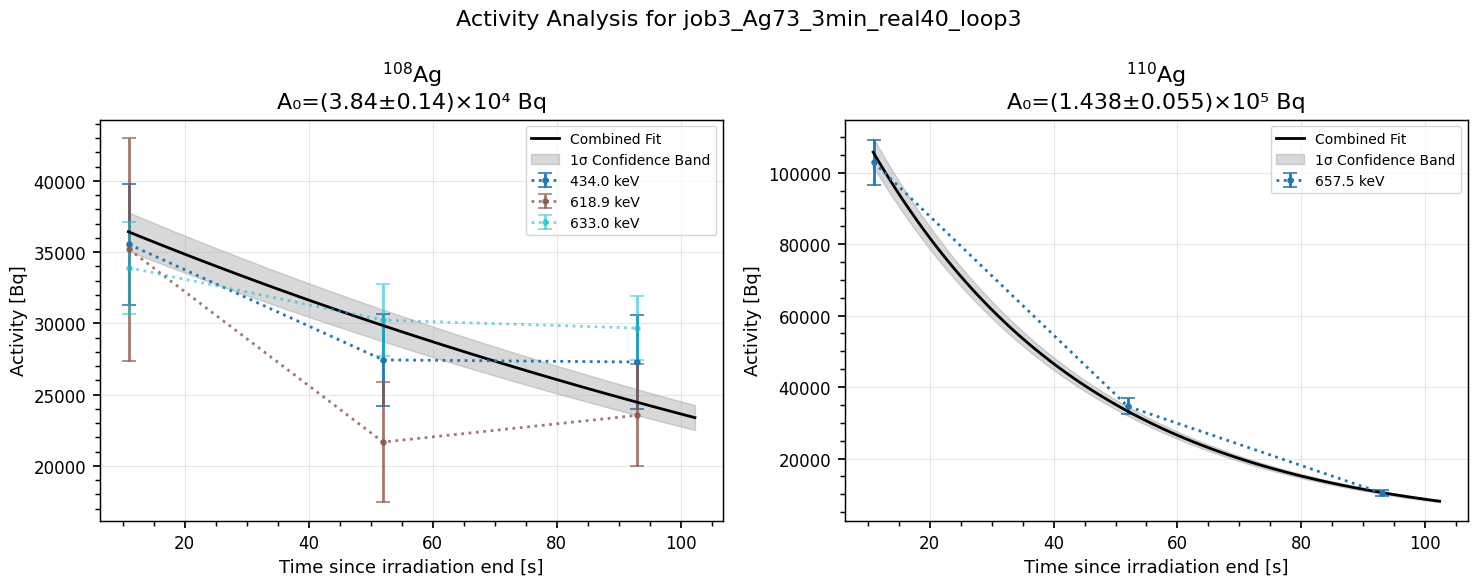

In [7]:
job3_analysis = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)  # type: ignore
job3_analysis.plot_activity()

#### **Job 4:**
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job4_Ag2_3min_real120_loop1_000.Spe


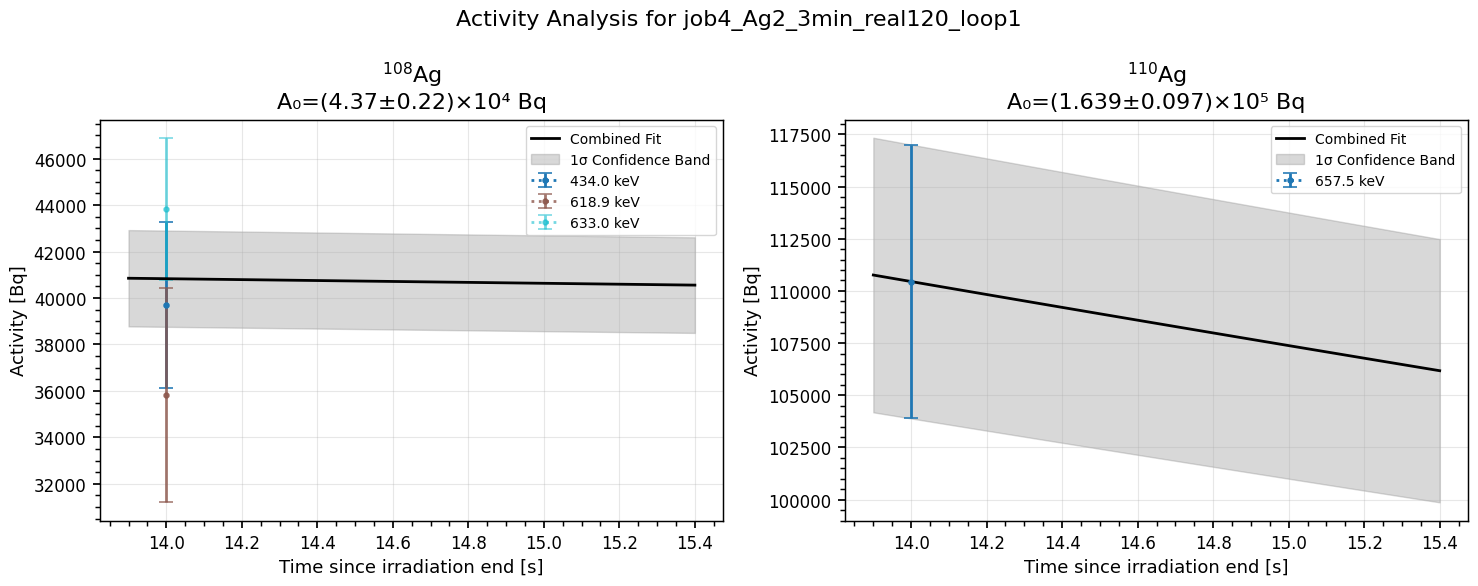

In [8]:
job4_analysis = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)  # type: ignore
job4_analysis.plot_activity()

#### **Job 5:**
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_004.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_005.Spe


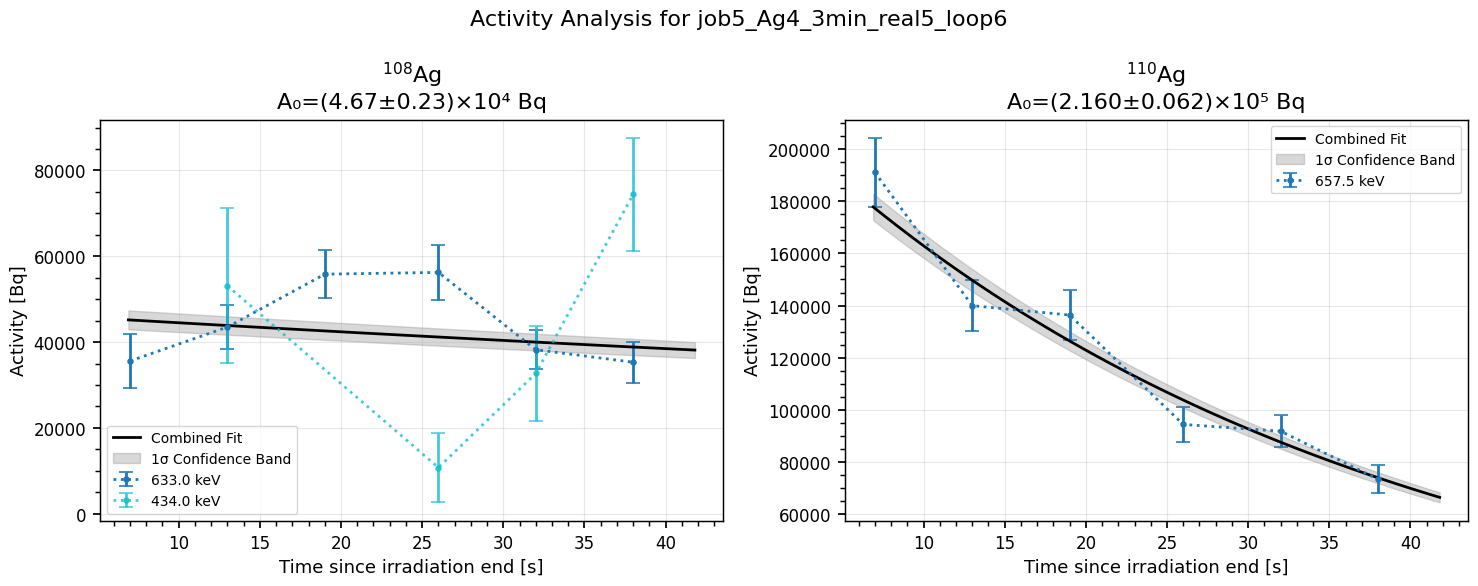

In [9]:
job5_analysis = SpectrumAnalysis(spec_exp_path / 'job5_Ag4_3min_real5_loop6', Δt_d=7)  # type: ignore
job5_analysis.plot_activity()

<br>

#### **Initial Activity and Production Rate Analysis**

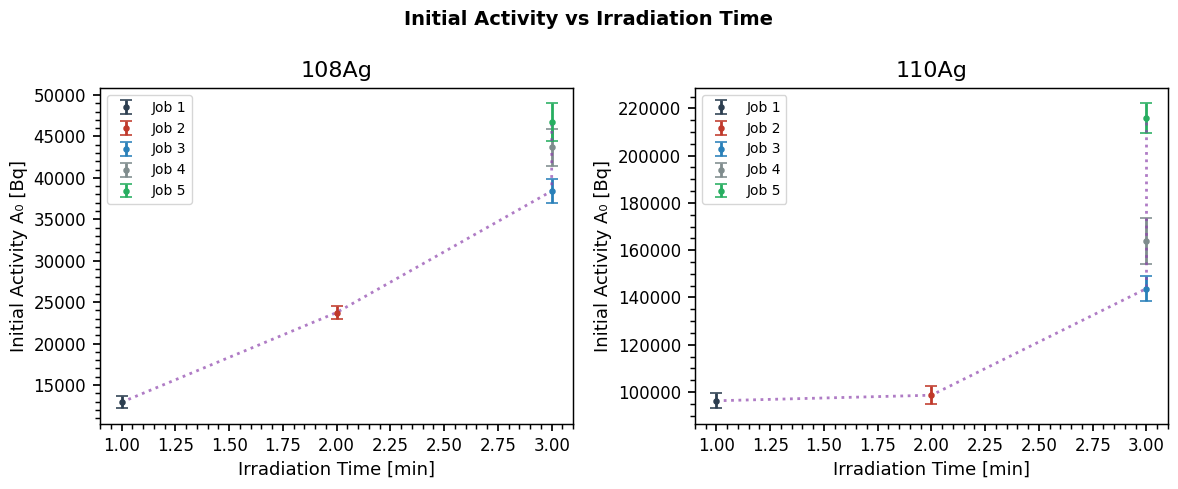

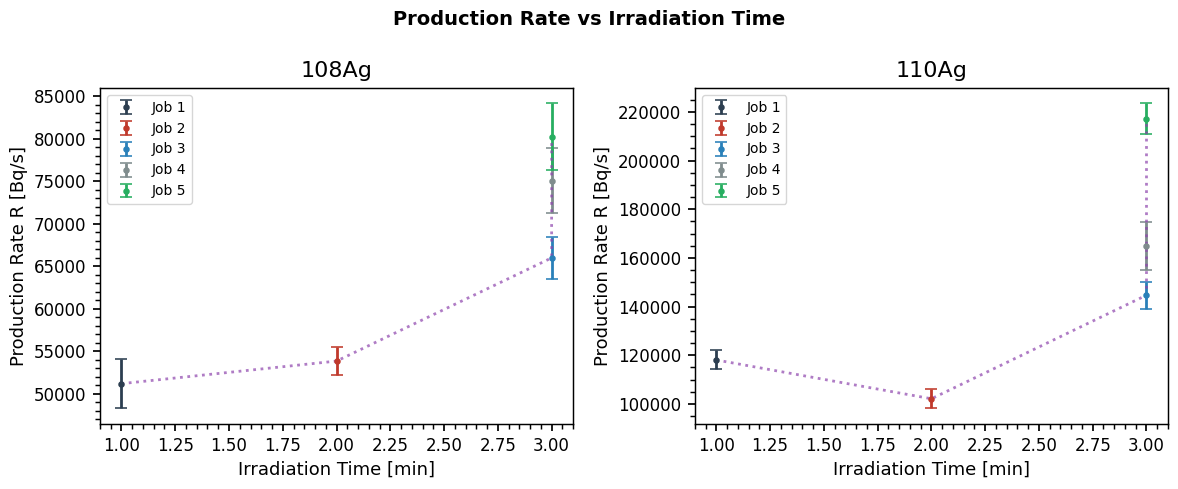

In [10]:
analyses = [job1_analysis, job2_analysis, job3_analysis, job4_analysis, job5_analysis]
job_names = [f"Job {i+1}" for i in range(len(analyses))]
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in analyses]

# Extract data for both isotopes
isotopes = ['108AG', '110AG']
data = {}
for isotope in isotopes:
    data[isotope] = {
        'A0': [analysis.get_isotope_results(isotope).A0.nominal_value for analysis in analyses],  # type: ignore
        'A0_unc': [analysis.get_isotope_results(isotope).A0.std_dev for analysis in analyses],  # type: ignore
        'λ': ci.Isotope(isotope).decay_const()
    }
    # Calculate production rates
    data[isotope]['R'] = [A0 / (1 - np.exp(-data[isotope]['λ'] * irr * 60)) for A0, irr in zip(data[isotope]['A0'], irradiation_times)]
    data[isotope]['R_unc'] = [unc / (1 - np.exp(-data[isotope]['λ'] * irr * 60)) for unc, irr in zip(data[isotope]['A0_unc'], irradiation_times)]


# Create separate plots
plot_configs = [
    ('A0', 'Initial Activity A₀ [Bq]', 'Initial Activity vs Irradiation Time', 'initial_activity_vs_irradiation_time'),
    ('R', 'Production Rate R [Bq/s]', 'Production Rate vs Irradiation Time', 'production_rate_vs_irradiation_time')
]

for metric, ylabel, title, filename in plot_configs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for col, isotope in enumerate(isotopes):
        ax = axes[col]
        
        # Plot data points with error bars
        for irr, val, unc, job in zip(irradiation_times, data[isotope][metric], data[isotope][f'{metric}_unc'], job_names):
            ax.errorbar(irr, val, yerr=unc, fmt='o', label=job)
        
        # Plot connecting line
        ax.plot(irradiation_times, data[isotope][metric], linestyle=':', alpha=0.7)
        
        ax.set_xlabel('Irradiation Time [min]')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{isotope.replace("AG", "Ag")}')
        ax.legend()
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fig_path / 'activity_analysis' / f'{filename}.pdf')
    plt.savefig(fig_path / 'activity_analysis' / f'{filename}.png')
    plt.show()

<br><br>

## **Cross-Section Analysis**

### **Product Nuclide Overview**

This analysis identifies possible radioactive isotopes that can be produced when irradiating our target and monitor foils with protons.

*Target foils:*
  - $^{\text{nat}}\text{Ga}$
  - $^{\text{nat}}\text{Sn}$

*Monitor foils:*
  - $^{\text{nat}}\text{Ni}$
  - $^{\text{nat}}\text{Cu}$

<br>

#### **Target Foils**

**$^{\text{nat}}\text{Ga}$**

In [ ]:
csa_Ga = CrossSectionAnalysis(target="Ga", particle_beam="proton", n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)
df_Ga = csa_Ga.isotope_overview(print_markdown=True, copy_to_clipboard=False)

Found 22/63 isotopes for observation:
65Zn 61Cu 61Co 60Co 59Fe 66Ge 67Ge 63Zn 68Ga 65Ni 66Ga 71Ge 67Ga 69Ge 64Cu 70Ga 68Ge 62Zn 65Ga 69Zn 67Cu 66Ni

Found 8/63 grayzone isotopes:
62Fe 62Cu 64Ga 61Fe 66Cu 69Cu 64Ge 62Co


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 72Ge      | Stable      | ✘        |
| 71Ge      | 11 d        | ✔        |
| 70Ge      | Stable      | ✘        |
| 69Ge      | 1.6 d       | ✔        |
| 68Ge      | 2.7e+02 d   | ✔        |
| 67Ge      | 19 m        | ✔        |
| 66Ge      | 2.3 h       | ✔        |
| 65Ge      | 31 s        | ✘        |
| 64Ge      | 1.1 m       | ~        |
| 71Ga      | Stable      | ✘        |
| 70Ga      | 21 m        | ✔        |
| 69Ga      | Stable      | ✘        |
| 68Ga      | 1.1 h       | ✔        |
| 67Ga      | 3.3 d       | ✔        |
| 66Ga      | 9.5 h       | ✔        |
| 65Ga      | 15 m        | ✔        |
| 64Ga      | 2.6 m       | ~        |
| 63Ga      | 32 s        | ✘        |

<br>

**$^{\text{nat}}\text{Sn}$**

In [23]:
csa_Sn = CrossSectionAnalysis(target="Sn")
df_Sn = csa_Sn.isotope_overview(print_markdown=True)

Found 45/133 isotopes for observation:
104Ag 109Cd 111Sn 102Rh 109Pd 108Sn 104Cd 108In 109Sn 107In 106Ag 125Sb 101Rh 112Pd 109In 115Ag 110In 117Cd 118Cd 103Pd 117In 111Pd 116Sb 115Sb 120Sb 107Rh 115Cd 112In 107Cd 113Sn 121Sn 105Ag 105Cd 117Sb 105Rh 111Ag 112Ag 111In 123Sn 119Sb 122Sb 124Sb 113Ag 110Sn 103Ag

Found 17/133 grayzone isotopes:
107Sn 118Sb 114Pd 109Rh 113Sb 105In 111Sb 116Ag 106Sn 119In 114Sb 108Ag 113Pd 117Ag 119Cd 106In 114In


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 125Sb     | 2.8 y       | ✔        |
| 124Sb     | 60 d        | ✔        |
| 123Sb     | Stable      | ✘        |
| 122Sb     | 2.7 d       | ✔        |
| 121Sb     | Stable      | ✘        |
| 120Sb     | 16 m        | ✔        |
| 119Sb     | 1.6 d       | ✔        |
| 118Sb     | 3.6 m       | ~        |
| 117Sb     | 2.8 h       | ✔        |
| 116Sb     | 16 m        | ✔        |
| 115Sb     | 32 m        | ✔        |
| 114Sb     | 3.5 m       | ~        |
| 113Sb 

<br>

#### **Monitor Foils**

**$^{\text{nat}}\text{Cu}$**

In [24]:
csa_Cu = CrossSectionAnalysis(target="Cu")
df_Cu = csa_Cu.isotope_overview(print_markdown=True)

Found 18/63 isotopes for observation:
65Zn 61Cu 61Co 56Mn 60Cu 60Co 63Zn 58Co 56Co 55Co 64Cu 55Fe 62Zn 57Ni 56Ni 57Co 54Mn 59Fe

Found 10/63 grayzone isotopes:
60Zn 62Fe 62Cu 55Cr 57Mn 61Fe 61Zn 59Cu 56Cr 62Co


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 66Zn      | Stable      | ✘        |
| 65Zn      | 2.4e+02 d   | ✔        |
| 64Zn      | Stable      | ✘        |
| 63Zn      | 38 m        | ✔        |
| 62Zn      | 9.3 h       | ✔        |
| 61Zn      | 1.5 m       | ~        |
| 60Zn      | 2.4 m       | ~        |
| 59Zn      | 1.8e+02 ms  | ✘        |
| 58Zn      | 84 ms       | ✘        |
| 65Cu      | Stable      | ✘        |
| 64Cu      | 13 h        | ✔        |
| 63Cu      | Stable      | ✘        |
| 62Cu      | 9.7 m       | ~        |
| 61Cu      | 3.3 h       | ✔        |
| 60Cu      | 24 m        | ✔        |
| 59Cu      | 1.4 m       | ~        |
| 58Cu      | 3.2 s       | ✘        |
| 57Cu      | 2e+02 ms    | ✘        |
| 64Ni  

**$^{\text{nat}}\text{Ni}$**

In [25]:
csa_Ni = CrossSectionAnalysis(target="Ni")
df_Ni = csa_Ni.isotope_overview(print_markdown=True)

Found 24/91 isotopes for observation:
61Co 49V 60Co 47V 51Cr 57Ni 59Fe 48V 58Co 51Mn 64Cu 55Fe 56Ni 48Cr 49Cr 56Co 61Cu 52Mn 56Mn 60Cu 52Fe 55Co 57Co 54Mn

Found 11/91 grayzone isotopes:
57Mn 59Cu 53Fe 62Cu 55Cr 61Fe 62Co 53V 62Fe 52V 56Cr


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 65Cu      | Stable      | ✘        |
| 64Cu      | 13 h        | ✔        |
| 63Cu      | Stable      | ✘        |
| 62Cu      | 9.7 m       | ~        |
| 61Cu      | 3.3 h       | ✔        |
| 60Cu      | 24 m        | ✔        |
| 59Cu      | 1.4 m       | ~        |
| 58Cu      | 3.2 s       | ✘        |
| 57Cu      | 2e+02 ms    | ✘        |
| 56Cu      | 94 ms       | ✘        |
| 55Cu      | 40 ms       | ✘        |
| 54Cu      | 75 ns       | ✘        |
| 53Cu      | 3e+02 ns    | ✘        |
| 64Ni      | Stable      | ✘        |
| 63Ni      | 1e+02 y     | ✘        |
| 62Ni      | Stable      | ✘        |
| 61Ni      | Stable      | ✘        |
| 60Ni      | Sta

<br><br>

### **Cross-Section Evaluation**

#### **Target Foils**

##### **Ga**

In [ ]:
# csa_Ga.save_tendl_data(path = tendl_data_path / "Ga")

# Load the TENDL data for Gallium
(fig_path / "cross_section_analysis").mkdir(parents=True, exist_ok=True)
csa_Ga.load_tendl_data(path = tendl_data_path / "Ga")

# Filter isotopes based on cross-section threshold and energy limit
sorted_filtered_isotopes_Ga = csa_Ga.filter_products_Cs(Cs_threshold=1e-2, E_limit=60, E_beam=None)  # type: ignore
csa_Ga.plot_Cs(title=r"Cross-section data for $^{\text{nat}}$Ga isotopes", isotopes=sorted_filtered_isotopes_Ga, low_Cs_threshold=10)
plt.savefig(fig_path / "cross_section_analysis" / "Ga_filtered_Cs.pdf")
plt.show()

Found 21/22 isotopes with cross-sections above 0.01 mb:
69Ge 68Ga 67Ga 71Ge 68Ge 65Zn 66Ga 70Ga 67Ge 65Ga 64Cu 63Zn 69Zn 66Ge 62Zn 67Cu 60Co 61Cu 65Ni 61Co 66Ni


Found 5/5 isotopes with cross-sections above 0.01 mb:
62Cu 66Cu 69Cu 64Ga 62Co


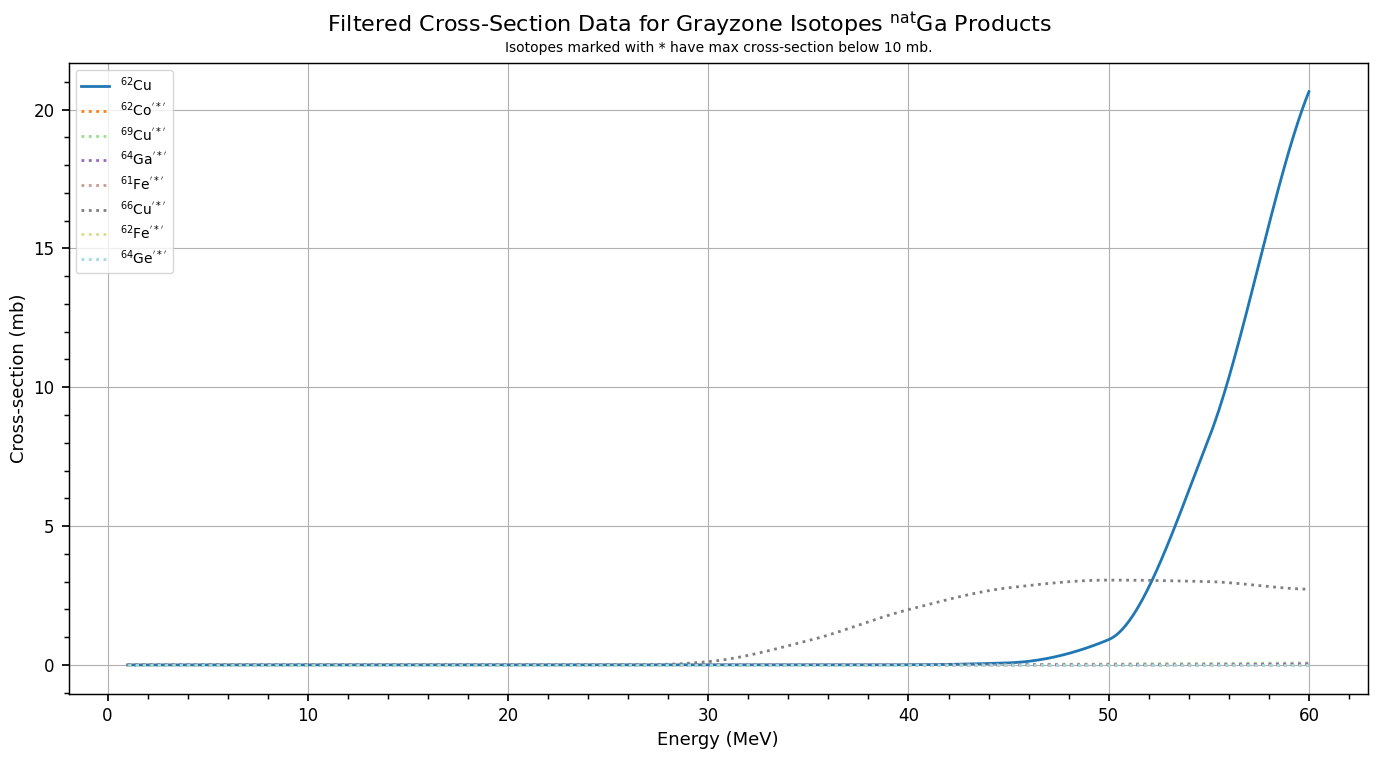

In [ ]:
grayzone_products_Ga = csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga', isotopes=csa_Ga.grayzone_isotopes)

sorted_filtered_grayzone_isotopes_Ga = csa_Ga.filter_products_Cs(isotopes=grayzone_products_Ga['Name'], Cs_threshold=1e-2, E_limit=60, E_beam=None)

csa_Ga.plot_Cs(title=r'Filtered Cross-Section Data for Grayzone Isotopes $^{\text{nat}}$Ga Products', isotopes=grayzone_products_Ga)
plt.savefig(fig_path / 'cross_section_analysis' / 'Ga_grayzone_filtered_Cs.pdf')
plt.show()

Sn

In [ ]:
# csa_Sn.save_tendl_data(path = tendl_data_path / 'Sn')

Found 31/31 isotopes with cross-sections above 0.01 mb:
119Sb 117Sb 120Sb 116Sb 115Sb 113Sn 122Sb 121Sn 124Sb 117In 123Sn 111Sn 112In 111In 110In 110Sn 109In 109Sn 109Cd 108In 107In 108Sn 107Cd 115Cd 105Cd 125Sb 106Ag 111Ag 117Cd 118Cd 105Ag


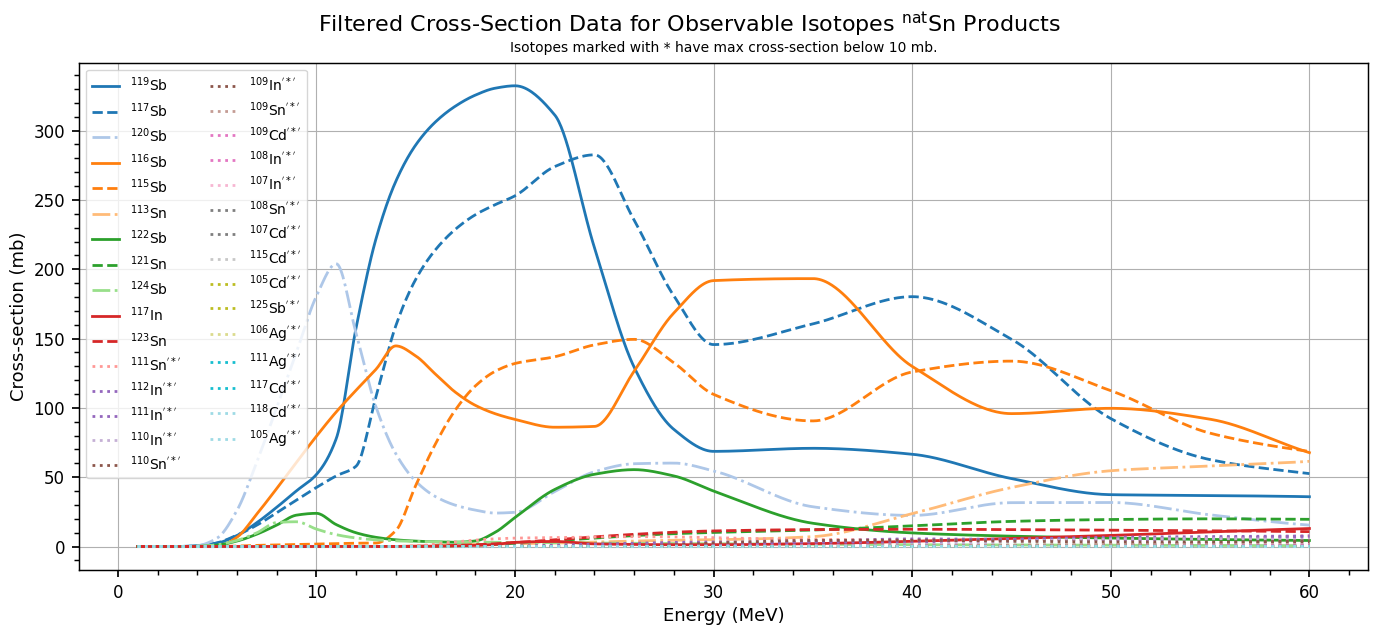

In [ ]:
csa_Sn.load_tendl_data(path = tendl_data_path / 'Sn')

sorted_filtered_isotopes_Sn = csa_Sn.filter_products_Cs()
csa_Sn.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Sn Products', isotopes=sorted_filtered_isotopes_Sn)
plt.legend(loc='upper left', ncol=2)
plt.savefig(fig_path /'cross_section_analysis' / 'Sn_filtered_Cs.pdf')
plt.show()

<br>

#### **Monitor Foils**

Cu

In [ ]:
# csa_Cu.save_tendl_data(path = tendl_data_path / 'Cu')

Found 18/18 isotopes with cross-sections above 0.01 mb:
63Zn 65Zn 61Cu 64Cu 62Zn 57Co 58Co 60Cu 60Co 56Co 57Ni 55Fe 61Co 54Mn 59Fe 56Mn 56Ni 55Co


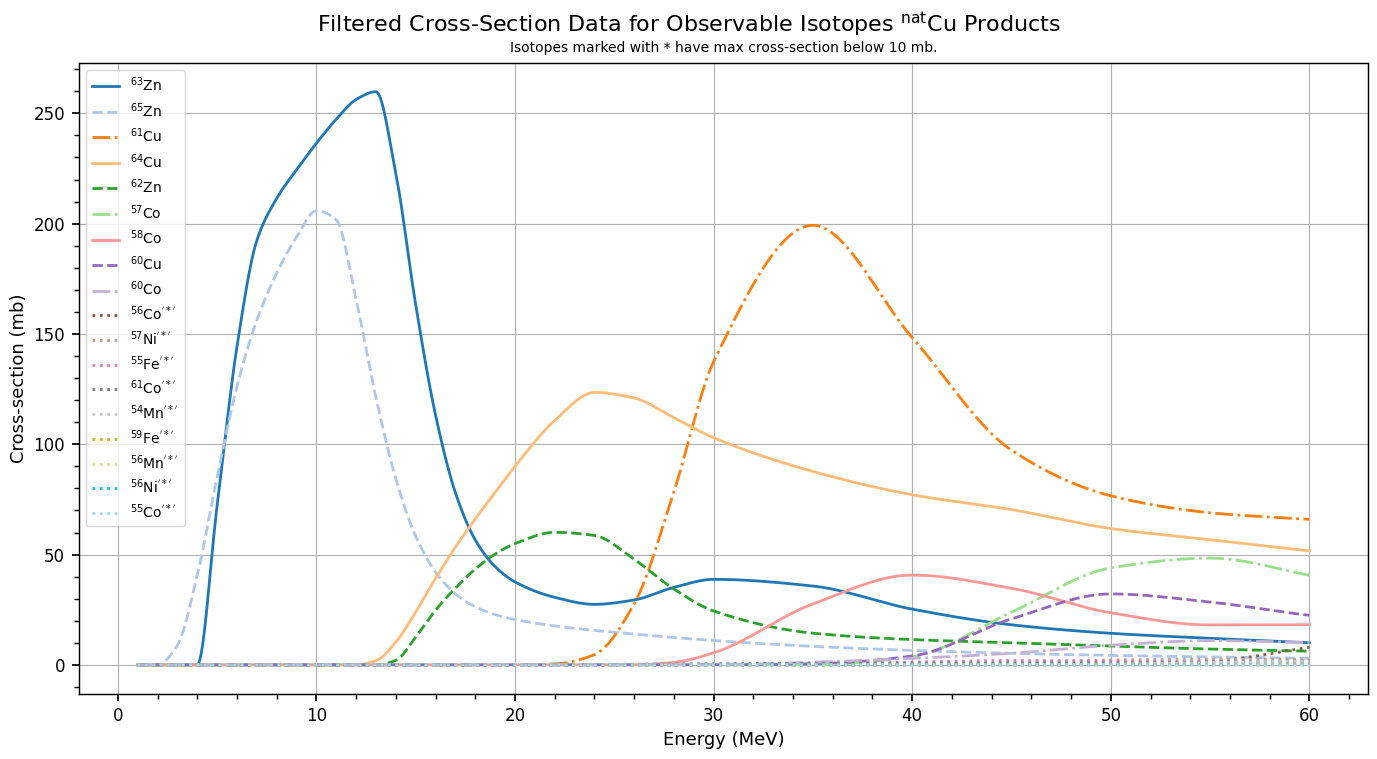

In [ ]:
csa_Cu.load_tendl_data(path = tendl_data_path / 'Cu')

sorted_filtered_isotopes_Cu = csa_Cu.filter_products_Cs()
csa_Cu.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Cu Products', isotopes=sorted_filtered_isotopes_Cu)
plt.savefig(fig_path / 'cross_section_analysis' / 'Cu_filtered_Cs.pdf')
plt.show()

Ni

In [ ]:
# csa_Ni.save_tendl_data(path = tendl_data_path / 'Ni')

Found 21/21 isotopes with cross-sections above 0.01 mb:
57Co 56Co 57Ni 55Fe 60Cu 58Co 55Co 52Mn 56Ni 61Cu 54Mn 64Cu 60Co 51Cr 61Co 52Fe 51Mn 49V 49Cr 59Fe 56Mn


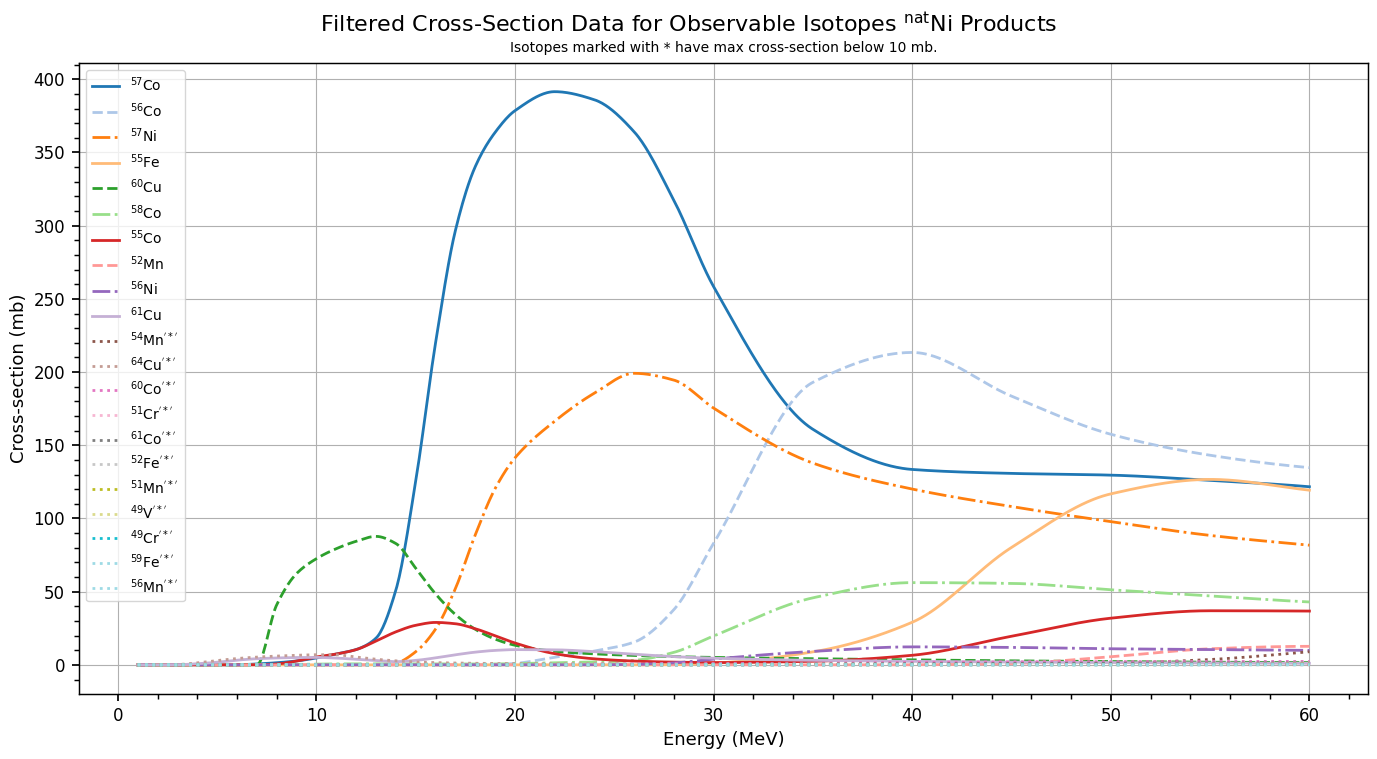

In [ ]:
csa_Ni.load_tendl_data(path = tendl_data_path / 'Ni')

sorted_filtered_isotopes_Ni = csa_Ni.filter_products_Cs()
csa_Ni.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ni Products', isotopes=sorted_filtered_isotopes_Ni)
plt.savefig(fig_path / 'cross_section_analysis' / 'Ni_filtered_Cs.pdf')
plt.show()

<br><br>

## **Stack Analysis & Counting Time Calculation**

In [ ]:
## Compound must be specified, and enough info to determine areal density
## Units:
## thickness: mm
## mass: g
## area: cm^2
## ad (areal density): mg/cm^2
## density: g/cm^3

x_kapton = 0.013
x_silicone = 0.013

ad_degrader_a = 599.   #2.24 mm
ad_degrader_b = 415.0   #1.55 mm
ad_degrader_c = 261.5   #0.97 mm
# ad_degrader_d = 599.0
ad_degrader_e = 68.3   #0.256 mm
ad_degrader_h = 33.8

ad_be_backing = 4.425     #23.9130435 microns

# for i in np.arange(1,11):
# 	print(i)

# 
# 55 MeV stack
# 

stack = []
for i,mult in zip(np.arange(1,8),[ad_degrader_c,ad_degrader_c,ad_degrader_c,ad_degrader_c,3*ad_degrader_e,3*ad_degrader_e,3*ad_degrader_e]):
    d = [
    {'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
            {'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
            {'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
            {'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
            {'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
    # print(d)
    stack = stack + d
    # stack.update(d)

# 
# 30 MeV stack
# 

# stack = []
# for i,mult in zip(np.arange(8,15),[2*ad_degrader_e,2*ad_degrader_e,2*ad_degrader_e,ad_degrader_e,ad_degrader_e,68.75,0.01]):
# 	d = [{'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
# 			{'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
# 			{'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
# 	# print(d)
# 	stack = stack+ d
# 	# stack.update(d)

# print(stack)


# # cm = ci.Compound('RbF', density=3.56)
# # print(cm.weights)


# print('Running...')
# # st = ci.Stack(stack, compounds={'RbF':{'Cu':-66, 'Zn':-33}}, E0=60.0)

st = ci.Stack(stack, E0=55.0, particle='p', dE0=0.55, N=1E4, max_steps=100)
# st = ci.Stack(stack, E0=30.0, particle='p', dE0=0.30, N=1E4, max_steps=100)
# st.saveas('lbnl_GaSn_stack_30MeV.csv')
# st.saveas('lbnl_GaSn_stack_30MeV.db')
# st.saveas('lbnl_GaSn_stack_55MeV.csv')
# st.saveas('lbnl_GaSn_stack_55MeV.db')
# # st.saveas('lbnl_w_stack.db')
# # st.saveas('lbnl_pa_stack.csv')
# st.summarize()
print(st.stack.columns)
st.plot('Ga')

ValueError: '28' is not in list

In [ ]:
Φ = 6.24e11  # Proton flux in protons/cm^2/s
t_irr = 60 * 60  # Irradiation time in seconds (1

sa = StackAnalysis(st, efficiency_func=cb.eff, proton_flux=Φ, irradiation_time=t_irr)

NameError: name 'st' is not defined

In [ ]:
products = {'Ga': sorted_filtered_isotopes_Ga,
            'Sn': sorted_filtered_isotopes_Sn,
            'Cu': sorted_filtered_isotopes_Cu,
            'Ni': sorted_filtered_isotopes_Ni}

results = sa.analyze(products=products, t_d=np.arange(0, 60*60*24*3), t_max=60*60, min_intensity=10.0, dE_511=0.1, silent=True)
print(results.head())

NameError: name 'sa' is not defined

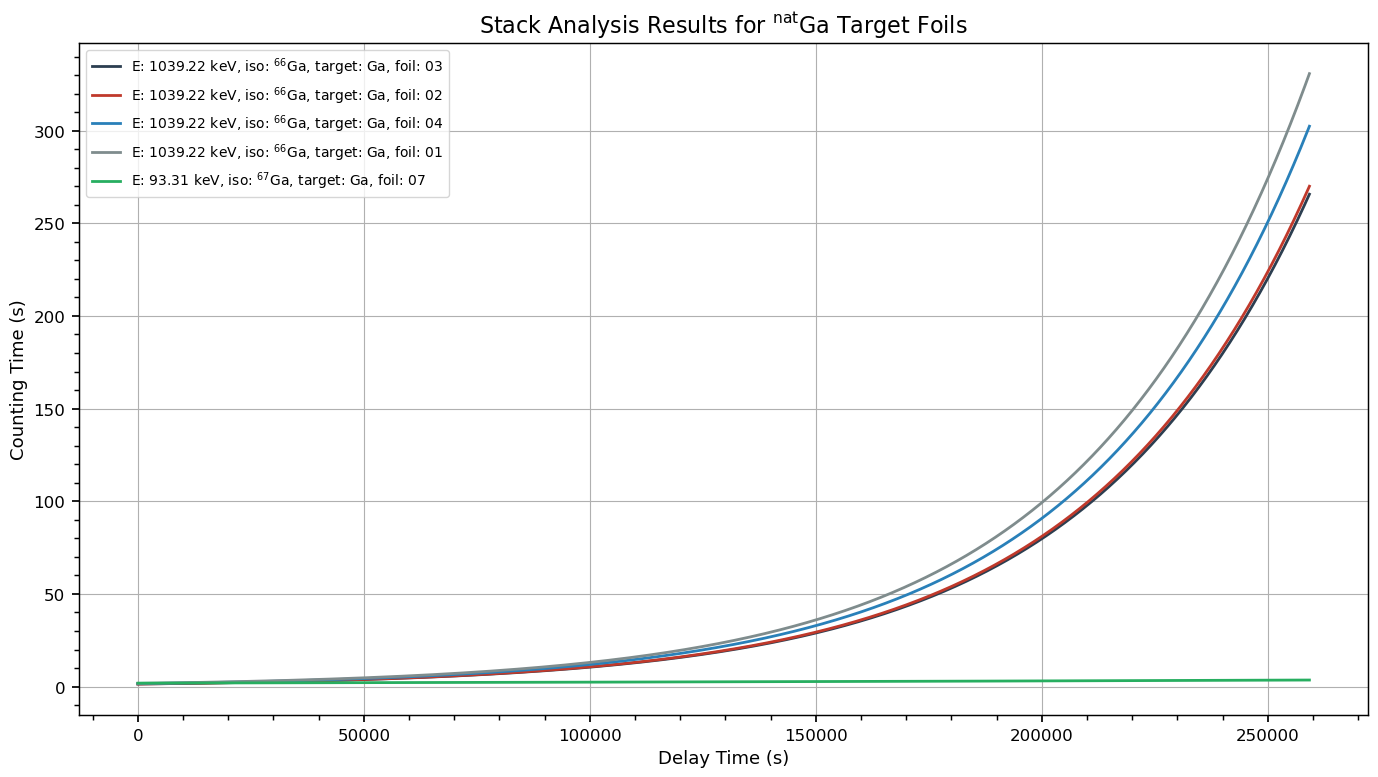

In [ ]:
sa.plot(results, target='Ga', title=r'Stack Analysis Results for $^{\text{nat}}$Ga Target Foils')
plt.show()